# SVM 支持向量机

**仍存在问题：**
    经验证，训练集拟合效果仅为50%，学习效果不好。
    后续再增加数据集，查找一下具体问题

为了使不同label的数据可以统一为 ： yi(WTxi+b)≥1

这里需要将数据集的label由0,1换为-1,1

参考文章 https://www.jiqizhixin.com/articles/2018-10-17-20

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mldataset as dataset
import math

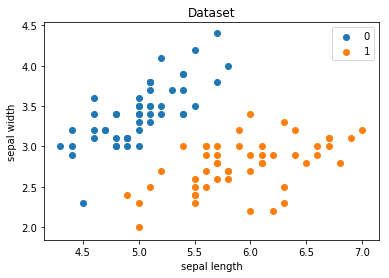

In [51]:
X, Y = dataset.iris()

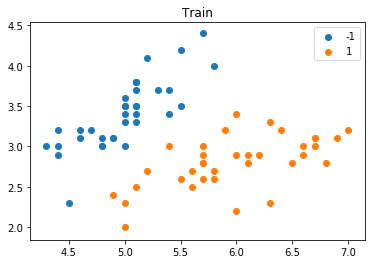

In [107]:
Y = np.array([-1.0 if i==0 else i for i in Y])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


plt.scatter([X_train[i][0] for i in range(len(X_train)) if Y_train[i]==-1], \
           [X_train[i][1] for i in range(len(X_train)) if Y_train[i]==-1], label="-1")
plt.scatter([X_train[i][0] for i in range(len(X_train)) if Y_train[i]==1], \
           [X_train[i][1] for i in range(len(X_train)) if Y_train[i]==1], label="1")
plt.title("Train")
plt.legend()

In [113]:
class SVM(object):
    def __init__(self, max_iter=300, C=1.0):
        self.max_iter = max_iter
        self.C = C
        self.m, self.n = None, None
        self.X, self.Y = None, None
        self.alpha = None
        self.b = 0.0
        self.E = []
        
    def kernel_func(self, x1, x2):
        '''poly   p=2'''
        return math.pow(sum([x1[i]*x2[i] for i in range(len(x1))]) + 1, 2)
    
    def g_x(self, pos):
        '''input a data index, calc with the whole dataset'''
        g = sum([self.alpha[j]*self.Y[j]*self.kernel_func(self.X[j], self.X[pos]) for j in range(self.m)])+self.b
        return g
        
    def kkt(self, pos):
        '''kkt条件 input:index'''
        if self.alpha[pos] == 0 and self.Y[pos]*self.g_x(pos)>=1:
            return True
        elif self.alpha[pos] == self.C and self.Y[pos]*self.g_x(pos)<=1:
            return True
        elif (self.alpha[pos]>0 and self.alpha[pos]<self.C) and self.Y[pos]*self.g_x(pos)>=1:
            return True
        else:
            return False
        
    def fit(self, X_train=X_train, Y_train=X_train, X_test=np.array([]), Y_test=np.array([])):
        '''train svm model'''
        self.X, self.Y = X_train, Y_train
        self.m, self.n = X_train.shape
        self.alpha = np.ones(self.m)
        self.E = [self.g_x(i)-self.Y[i] for i in range(self.m)]
        
        # start iteration
        for i in range(self.max_iter):
            # Outer traversal
            outers = [i for i in range(self.m) if (self.alpha[i]>0 and self.alpha[i]<self.C)]
            others = [j for j in range(self.m) if j not in outers]
            outers.extend(others)
            # print("outers = ", outers)
            for pos in outers:
                if self.kkt(pos):
                    continue    # 遍历找到不满足kkt的变量，先外层
                    
                E1, i1 = self.E[pos], pos
                if E1>=0:
                    E2, i2 = min(self.E), self.E.index(min(self.E))
                else:
                    E2, i2 = max(self.E), self.E.index(max(self.E))
                break
                  
            # find boundary L and H
            alpha1, alpha2 = self.alpha[i1], self.alpha[i2]

            y1, y2 = self.Y[i1], self.Y[i2]
            if y1==y2:
                L = max(0, alpha1 + alpha2 - self.C)
                H = min(self.C, alpha1 + alpha2)
            else:
                L = max(0, alpha2 - alpha1)
                H = min(self.C, self.C + alpha2 - alpha1)

                eta = self.kernel_func(self.X[i1], self.X[i1]) + self.kernel_func(self.X[i2], self.X[i2]) - \
                      2 * self.kernel_func(self.X[i1], self.X[i2])
                if eta <= 0:
                    continue
            
            # 计算沿约束方向未经剪辑时的解
            alpha2_new_unc = alpha2 + (self.Y[i2] * (E1 - E2))/eta
            
            # 计算剪辑后alpha2的解
            if alpha2_new_unc > H:
                alpha2_new = H
            elif alpha2_new_unc < L:
                alpha2_new = L
            else:
                alpha2_new = alpha2_new_unc
                
            alpha1_new = alpha1 + self.Y[i1] * self.Y[i2] * (alpha2 - alpha2_new)
            
            # 计算阈值b
            b1_new = -self.E[i1] - self.Y[i1]*self.kernel_func(self.X[i1], self.X[i1])*(alpha1_new-alpha1) - \
                     self.Y[i2]*self.kernel_func(self.X[i2], self.X[i1])*(alpha2_new-alpha2) + self.b
            b2_new = -self.E[i2] - self.Y[i1]*self.kernel_func(self.X[i1], self.X[i2])*(alpha1_new-alpha1) - \
                     self.Y[i2]*self.kernel_func(self.X[i2], self.X[i2])*(alpha2_new-alpha2) + self.b
            
            if alpha1_new > 0 and alpha1_new < self.C:
                b_new = b1_new
            elif alpha2_new > 0 and alpha2_new < self.C:
                b_new = b2_new
            elif (alpha1==0 or alpha1==self.C) or (alpha2==0 or alpha2==self.C):
                b_new = (b1_new + b2_new) / 2
            else:
                exit("alpha1 or alpha2 calculate error!")
                
                
            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new
            self.E[i1] = self.g_x(i1) - self.Y[i1]
            self.E[i2] = self.g_x(i2) - self.Y[i2]
            
        if X_test.shape!=(0.) and Y_test.shape!=(0.):
            acc = self.score(X_test, Y_test)
            return acc
            
    def predict(self, x_test):
        result = sum([self.alpha[i] * self.Y[i] * self.kernel_func(x_test, self.X[i]) for i in range(self.m)])
        if result > 0:
            return 1
        else:
            return -1
        
    def score(self, X_test, Y_test):
        right = 0
        for i in range(len(X_test)):
            if self.predict(X_test[i]) == Y_test[i]:
                right += 1
        return right / len(X_test)

In [114]:
svm = SVM()

In [115]:
svm.fit(X_train, Y_train, X_test, Y_test)

0.5

In [117]:
svm.score(X_train, Y_train)

0.5